# Preprocessing

Number of male files loaded: 120
Number of female files loaded: 120
Total balanced files loaded: 240
Processing: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_151501033_male.mp3
Original Sampling Rate: 44100, Duration: 14.88 seconds
Processed Signal: 1486 frames of size 400
Processing: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_159403005_male.mp3
Original Sampling Rate: 48000, Duration: 19.36 seconds
Processed Signal: 1934 frames of size 400
Processing: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610300017_male.mp3
Original Sampling Rate: 48000, Duration: 15.34 seconds
Processed Signal: 1532 frames of size 400
Processing: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610300032_male.mp3
Original Sampling Rate: 48000, Duration: 15.66 seconds
Processed Signal: 1564 frames of size 400
Processing: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610399182_male.mp3
Original Samplin

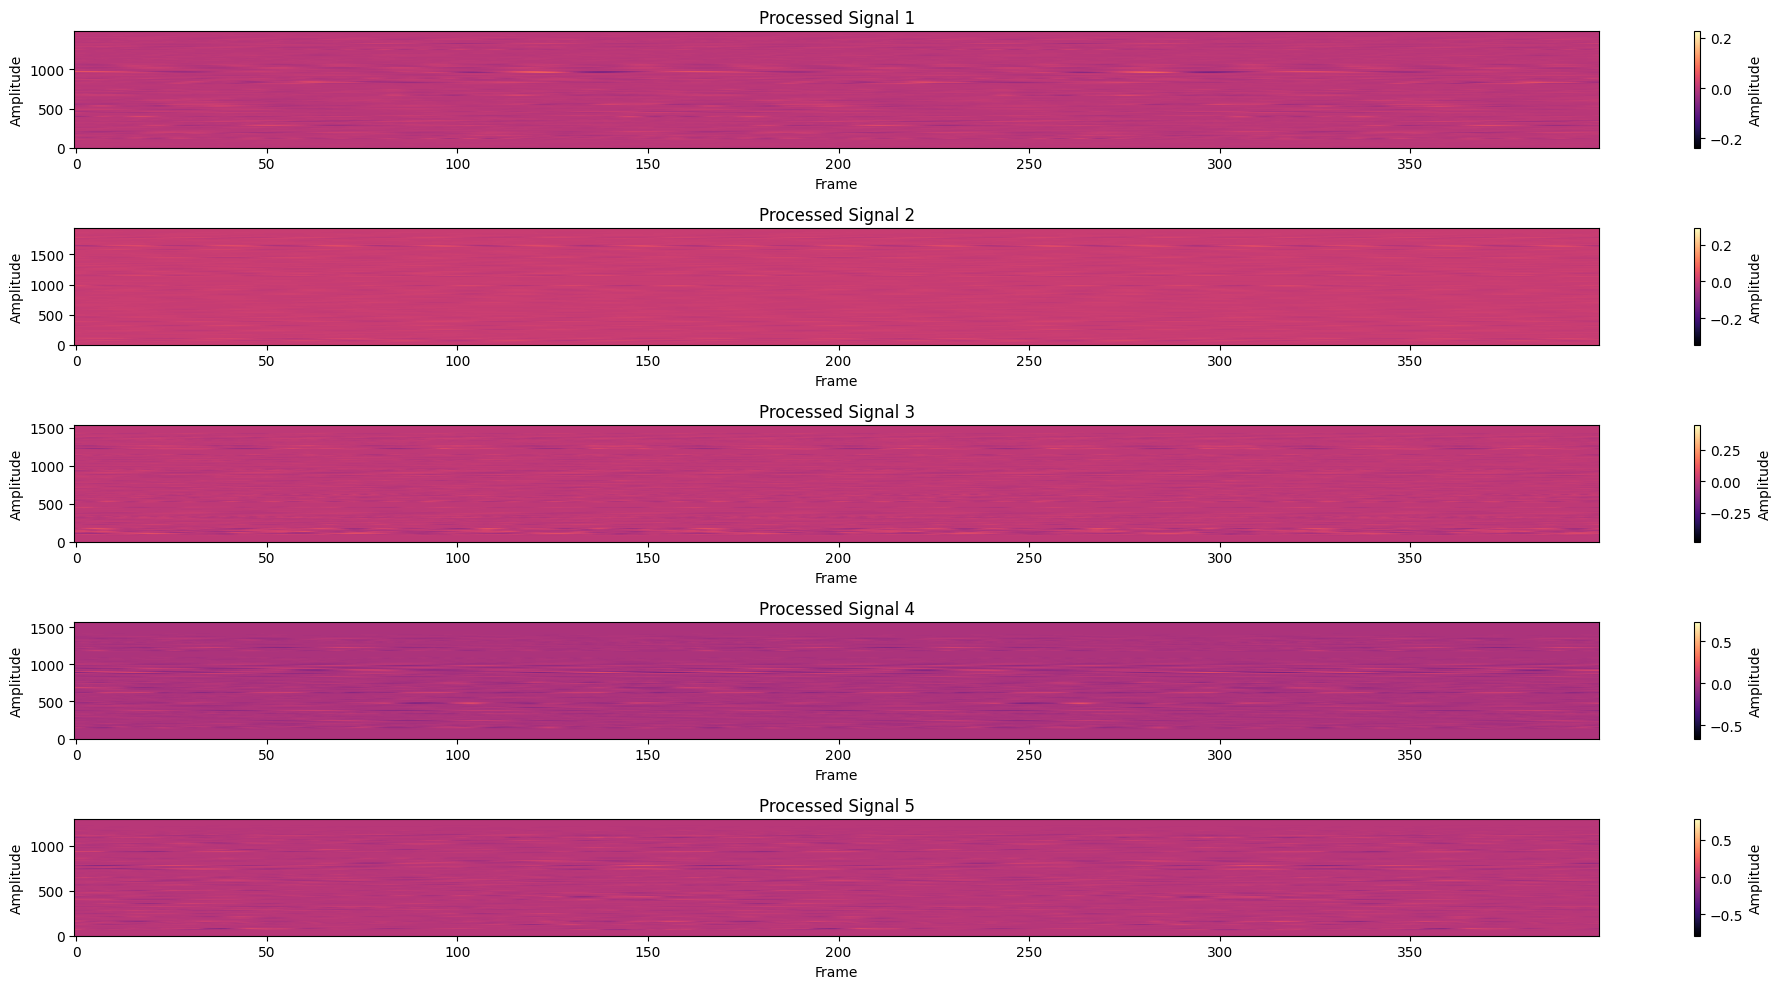

Generating spectrogram for file 1: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_151501033_male.mp3


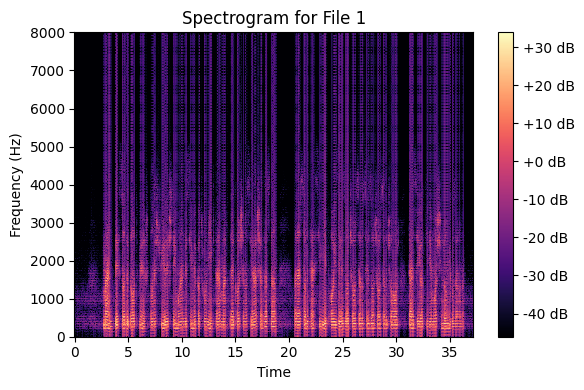

Generating spectrogram for file 2: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_159403005_male.mp3


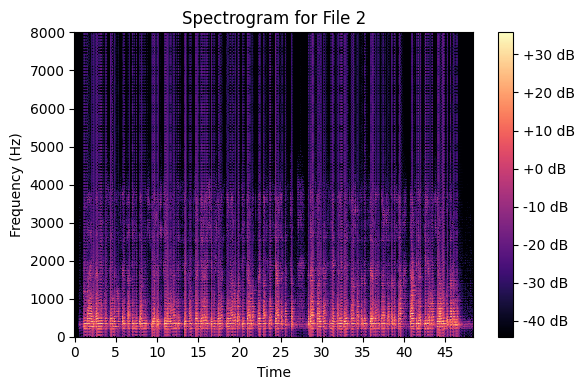

Generating spectrogram for file 3: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610300017_male.mp3


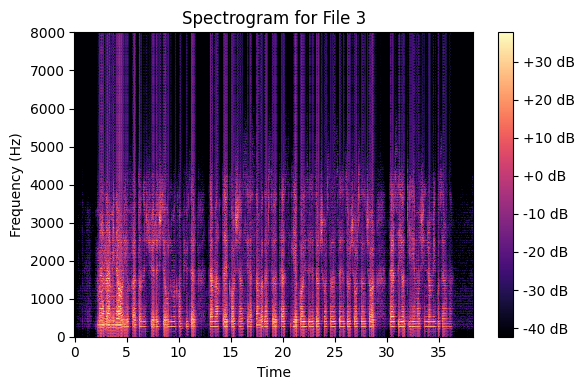

Generating spectrogram for file 4: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610300032_male.mp3


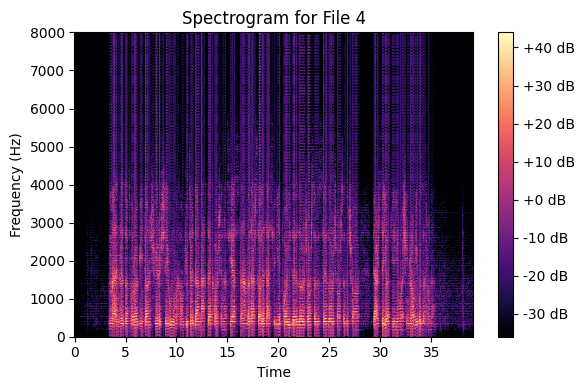

Generating spectrogram for file 5: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610399182_male.mp3


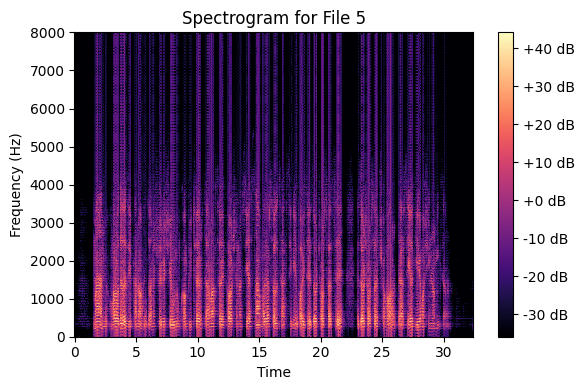

In [5]:
import os
import re
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import librosa.display

# Define bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Define the function to process audio files with a duration limit
def process_audio(file_path, lowcut=300.0, highcut=3400.0, target_sr=16000, window_size=0.025, window_stride=0.01, max_duration=30):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)
        print(f"Original Sampling Rate: {sr}, Duration: {len(y) / sr:.2f} seconds")

        # Trim audio to the first max_duration seconds
        max_samples = int(max_duration * sr)
        y = y[:max_samples]

        # Resample to the target sampling rate
        resampled_signal = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

        # Apply bandpass filtering
        filtered_signal = bandpass_filter(resampled_signal, lowcut, highcut, target_sr)

        # Normalize the audio signal (replace any non-numeric values)
        normalized_signal = np.nan_to_num(filtered_signal, nan=0.0, posinf=0.0, neginf=0.0)

        # Windowing
        frame_length = int(window_size * target_sr)  # Number of samples per frame
        frame_step = int(window_stride * target_sr)  # Number of samples per stride
        windows = librosa.util.frame(normalized_signal, frame_length=frame_length, hop_length=frame_step).T

        print(f"Processed Signal: {windows.shape[0]} frames of size {frame_length}")
        return windows
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Directory containing the audio files
audio_directory = r"E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M"

# Compile regex patterns for the two accepted formats
pattern1 = re.compile(r"^HW\d+_Q\d+_\d{9}_(male|female)\.mp3$", re.IGNORECASE)
pattern2 = re.compile(r"^HW\d+_intro_\d{9}_(male|female)\.mp3$", re.IGNORECASE)
patterns = [pattern1, pattern2]

# Filter files based on the naming convention and separate male and female files
male_files = []
female_files = []
for file in os.listdir(audio_directory):
    # Only process .mp3 files
    if not file.lower().endswith('.mp3'):
        continue

    # Check if the file matches one of the accepted formats
    for pattern in patterns:
        match = pattern.match(file)
        if match:
            gender = match.group(1).lower()
            if gender == 'male':
                male_files.append(os.path.join(audio_directory, file))
            elif gender == 'female':
                female_files.append(os.path.join(audio_directory, file))
            break  # Exit the loop if a pattern is matched

        # Optionally, balance the dataset by selecting a fixed number from each gender
# Here, we select up to 120 male and 120 female files each
male_files = male_files[:120]
female_files = female_files[:120]
balanced_files = male_files + female_files

print(f"Number of male files loaded: {len(male_files)}")
print(f"Number of female files loaded: {len(female_files)}")
print(f"Total balanced files loaded: {len(balanced_files)}")

# Process the balanced files
processed_data = []
for file_path in balanced_files:
    print(f"Processing: {file_path}")
    processed = process_audio(file_path)
    if processed is not None:
        processed_data.append(processed)

print(f"Processed {len(processed_data)} files successfully.")

# Visualize spectrogram-like representations of up to 5 processed signals
if len(processed_data) >= 5:
    plt.figure(figsize=(20, 10))
    for i in range(5):  # Visualize up to 5 processed signals
        plt.subplot(5, 1, i + 1)
        plt.imshow(processed_data[i], aspect='auto', origin='lower', cmap='magma')
        plt.title(f"Processed Signal {i + 1}")
        plt.xlabel("Frame")
        plt.ylabel("Amplitude")
        plt.colorbar(label="Amplitude", orientation="vertical")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough processed signals to visualize 5.")

# Function to compute and visualize frequency-domain spectrograms
def plot_frequency_domain_spectrogram(audio_data, sr, title="Frequency-Domain Spectrogram"):
    # Compute the Short-Time Fourier Transform (STFT)
    S = librosa.stft(audio_data.flatten(), n_fft=2048, hop_length=512)
    S_db = librosa.amplitude_to_db(abs(S))  # Convert amplitude to decibel scale

    # Plot the spectrogram
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Generate and visualize spectrograms for the first 5 files
for idx, file_path in enumerate(balanced_files[:5]):
    try:
        processed_audio = processed_data[idx]
        print(f"Generating spectrogram for file {idx + 1}: {file_path}")
        plot_frequency_domain_spectrogram(
            processed_audio.flatten(),
            sr=16000,
            title=f"Spectrogram for File {idx + 1}"
        )
    except Exception as e:
        print(f"Error generating spectrogram for file {file_path}: {e}")

# Feature Extraction

In [6]:
import os
import librosa
import numpy as np
import json
from collections import Counter

# Function to extract student ID from the file name
def extract_student_id(file_name):
    try:
        parts = file_name.split('_')
        student_id = parts[2]  # The ID is typically the third part
        return student_id
    except IndexError:
        return "unknown"

# Function to extract features
def extract_features(audio_data, sr):
    try:
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128, fmax=8000)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data)
        energy = librosa.feature.rms(y=audio_data)

        features = {
            "Log-Mel Spectrogram": log_mel_spectrogram.tolist(),
            "MFCC": mfccs.tolist(),
            "Spectral Centroid": spectral_centroid.tolist(),
            "Spectral Bandwidth": spectral_bandwidth.tolist(),
            "Spectral Contrast": spectral_contrast.tolist(),
            "Zero-Crossing Rate": zero_crossing_rate.tolist(),
            "Energy": energy.tolist()
        }
        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# Verify processed_data and balanced_files alignment
if len(processed_data) != len(balanced_files):
    raise ValueError("Mismatch between processed_data and balanced_files. Ensure they are aligned.")

# Extract features for all processed files
features_data = []
for idx, processed_audio in enumerate(processed_data):
    try:
        if isinstance(processed_audio, np.ndarray) and len(processed_audio.shape) > 1:
            audio_data = processed_audio.flatten()
        else:
            audio_data = processed_audio

        print(f"Extracting features for file {idx + 1}: {balanced_files[idx]}")

        # Check for the correct labels based on filename
        file_name = os.path.basename(balanced_files[idx]).lower()
        if "female" in file_name:
            label = "female"
        elif "male" in file_name:
            label = "male"
        else:
            label = "unknown"  # If neither "male" nor "female" is found
        
        print(f"Assigned label: {label}")

        features = extract_features(audio_data, sr=16000)

        if features:
            student_id = extract_student_id(balanced_files[idx])

            features_data.append({
                "file": balanced_files[idx],
                "label": label,
                "student_id": student_id,
                "features": features
            })

    except Exception as e:
        print(f"Error extracting features for file {balanced_files[idx]}: {e}")

# Save extracted features to JSON
output_file = "extracted_features_dataset.json"
with open(output_file, "w") as f:
    json.dump(features_data, f)

# Debugging: Check labels
binary_labels = [1 if entry['label'] == "male" else 0 for entry in features_data]
print(f"Class distribution: {Counter(binary_labels)}")

print(f"Extracted features for {len(features_data)} files successfully.")
print(f"Features saved to {output_file}")



Extracting features for file 1: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_151501033_male.mp3
Assigned label: male
Extracting features for file 2: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_159403005_male.mp3
Assigned label: male
Extracting features for file 3: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610300017_male.mp3
Assigned label: male
Extracting features for file 4: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610300032_male.mp3
Assigned label: male
Extracting features for file 5: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610399182_male.mp3
Assigned label: male
Extracting features for file 6: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610399205_male.mp3
Assigned label: male
Extracting features for file 7: E:\Semester 7\Machine Learning\Project\AudioDataSet\HW1_M\HW1_intro_610399206_male.mp3
Assigned label: male
Extracting features 

# Gender Classification: Logistic Regression

Cross-Validation Accuracy Scores: [0.94444444 0.94444444 0.86111111 0.91666667 0.94444444]
Mean CV Accuracy: 0.92
Optimal Threshold: 0.58

Default Accuracy: 0.98
Optimized Accuracy: 0.98

Classification Report (Default Threshold):
              precision    recall  f1-score   support

      Female       1.00      0.97      0.98        30
        Male       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60


Confusion Matrix (Default Threshold):
               Predicted Female  Predicted Male
Actual Female                29               1
Actual Male                   0              30

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Female       1.00      0.97      0.98        30
        Male       0.97      1.00      0.98        30

    accuracy                           0.98        

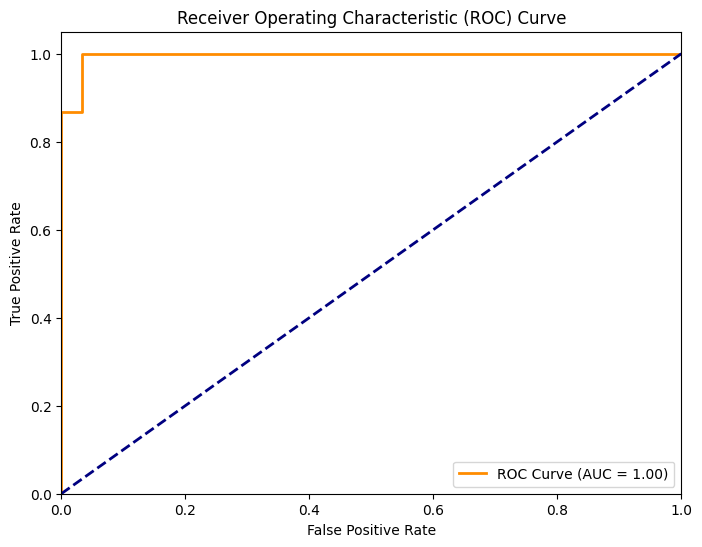

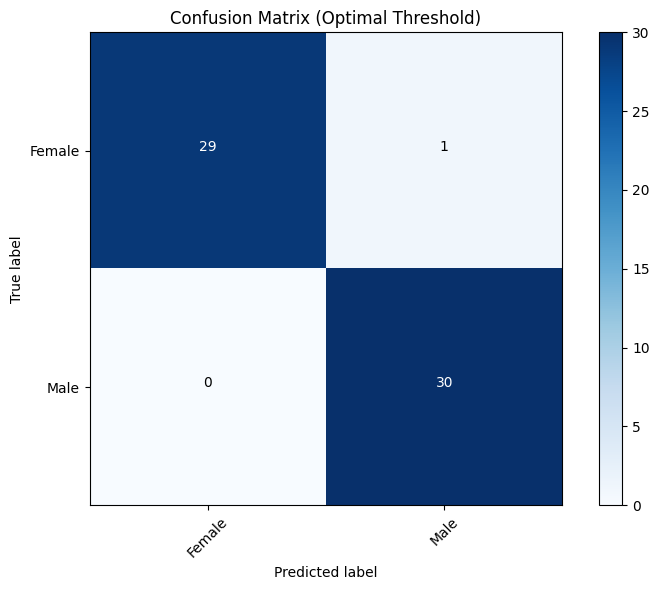

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

# Load features from JSON
def load_features(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    features = []
    labels = []
    for entry in data:
        label = 1 if entry['label'].lower() == 'male' else 0  # Convert gender to binary
        feature_vector = np.concatenate([
            np.mean(entry['features']['MFCC'], axis=1),  # Mean of MFCCs
            np.mean(entry['features']['Spectral Centroid'], axis=1),  # Mean of spectral centroid
            np.mean(entry['features']['Spectral Bandwidth'], axis=1)  # Mean of spectral bandwidth
        ])
        features.append(feature_vector)
        labels.append(label)
    return np.array(features), np.array(labels)

# Load the data
json_file = "extracted_features_dataset.json"
X, y = load_features(json_file)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation to evaluate model
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")

# Fit the model
model.fit(X_train, y_train)

# Predict Probabilities for the Test Set
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Predict Using the Default Threshold (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)
default_accuracy = accuracy_score(y_test, y_pred_default)
print(f"\nDefault Accuracy: {default_accuracy:.2f}")

# Predict Using the Optimal Threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
optimized_accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized Accuracy: {optimized_accuracy:.2f}")

# Confusion Matrix and Classification Report for Default Threshold
print("\nClassification Report (Default Threshold):")
print(classification_report(y_test, y_pred_default, target_names=["Female", "Male"]))

conf_matrix_default = confusion_matrix(y_test, y_pred_default)
print("\nConfusion Matrix (Default Threshold):")
print(pd.DataFrame(conf_matrix_default, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

# Confusion Matrix and Classification Report for Optimal Threshold
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal, target_names=["Female", "Male"]))

conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix (Optimal Threshold):")
print(pd.DataFrame(conf_matrix_optimal, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for Optimal Threshold
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_optimal, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Optimal Threshold)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Female", "Male"], rotation=45)
plt.yticks(tick_marks, ["Female", "Male"])
thresh = conf_matrix_optimal.max() / 2.0
for i, j in np.ndindex(conf_matrix_optimal.shape):
    plt.text(j, i, f"{conf_matrix_optimal[i, j]}", 
             horizontalalignment="center", 
             color="white" if conf_matrix_optimal[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


# Gender Classification: MLP

Optimal Threshold: 0.11

Default Accuracy: 0.95
Optimized Accuracy: 0.98

Classification Report (Default Threshold (0.5)):
              precision    recall  f1-score   support

      Female       0.94      0.97      0.95        30
        Male       0.97      0.93      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60


Confusion Matrix (Default Threshold (0.5)):
               Predicted Female  Predicted Male
Actual Female                29               1
Actual Male                   2              28


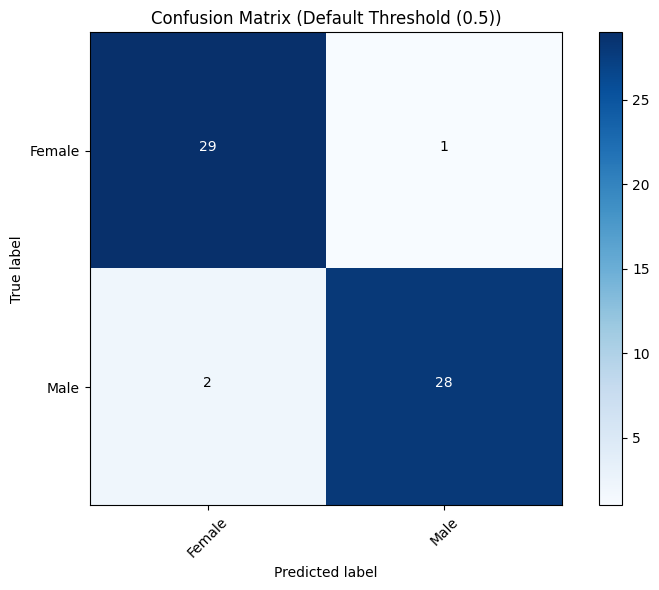


Classification Report (Optimized Threshold (0.11)):
              precision    recall  f1-score   support

      Female       1.00      0.97      0.98        30
        Male       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60


Confusion Matrix (Optimized Threshold (0.11)):
               Predicted Female  Predicted Male
Actual Female                29               1
Actual Male                   0              30


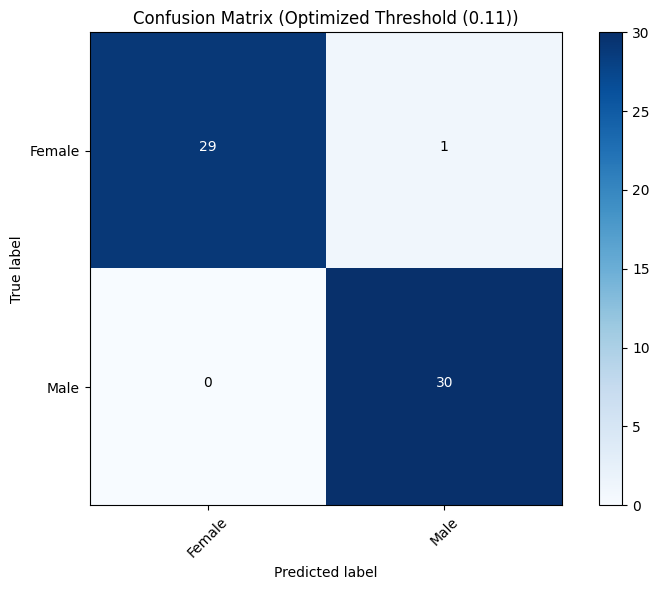

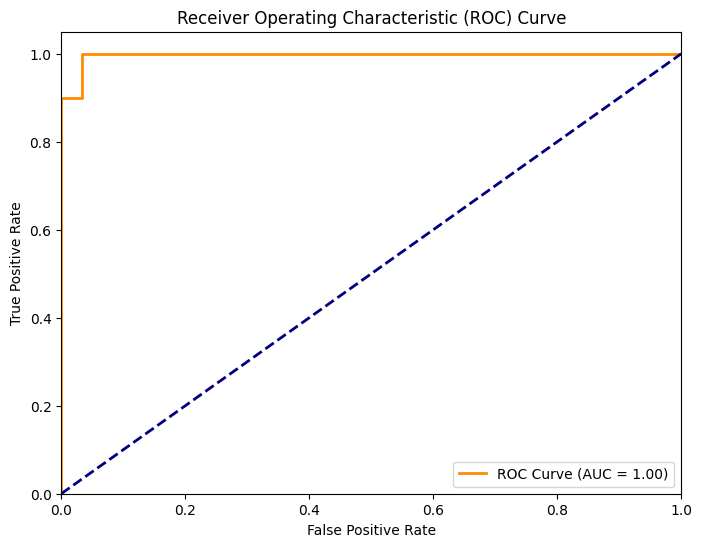

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd

# Load features from JSON
def load_features(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    features = []
    labels = []
    for entry in data:
        label = 1 if entry['label'].lower() == 'male' else 0  # Convert gender to binary
        feature_vector = np.concatenate([
            np.mean(entry['features']['MFCC'], axis=1),
            np.mean(entry['features']['Spectral Centroid'], axis=1),
            np.mean(entry['features']['Spectral Bandwidth'], axis=1)
        ])
        features.append(feature_vector)
        labels.append(label)
    return np.array(features), np.array(labels)

# Load and split the data
json_file = "extracted_features_dataset.json"
X, y = load_features(json_file)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Calibrate probabilities
calibrated_mlp = CalibratedClassifierCV(estimator=mlp, cv="prefit")
calibrated_mlp.fit(X_train, y_train)

# Predict probabilities for the test set
y_proba = calibrated_mlp.predict_proba(X_test)[:, 1]

# Determine the optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Predict using the default threshold (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)
default_accuracy = accuracy_score(y_test, y_pred_default)
print(f"\nDefault Accuracy: {default_accuracy:.2f}")

# Predict using the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
optimized_accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized Accuracy: {optimized_accuracy:.2f}")

# Evaluate and visualize results
def evaluate_predictions(y_test, y_pred, threshold_label):
    print(f"\nClassification Report ({threshold_label}):")
    print(classification_report(y_test, y_pred, target_names=["Female", "Male"]))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix ({threshold_label}):")
    print(pd.DataFrame(conf_matrix, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({threshold_label})")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Female", "Male"], rotation=45)
    plt.yticks(tick_marks, ["Female", "Male"])
    thresh = conf_matrix.max() / 2.0
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, f"{conf_matrix[i, j]}", 
                 horizontalalignment="center", 
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

# Evaluate default and optimized thresholds
evaluate_predictions(y_test, y_pred_default, "Default Threshold (0.5)")
evaluate_predictions(y_test, y_pred_optimal, f"Optimized Threshold ({optimal_threshold:.2f})")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# Gender Classification: KNN

Cross-Validation Accuracy Scores: [0.86111111 0.86111111 0.86111111 0.88888889 0.91666667]
Mean CV Accuracy: 0.88
Optimal Threshold: 0.60

Default Accuracy: 0.93
Optimized Accuracy: 0.93

Classification Report (Default Threshold):
              precision    recall  f1-score   support

      Female       0.93      0.93      0.93        30
        Male       0.93      0.93      0.93        30

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60


Confusion Matrix (Default Threshold):
               Predicted Female  Predicted Male
Actual Female                28               2
Actual Male                   2              28

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Female       0.93      0.93      0.93        30
        Male       0.93      0.93      0.93        30

    accuracy                           0.93        

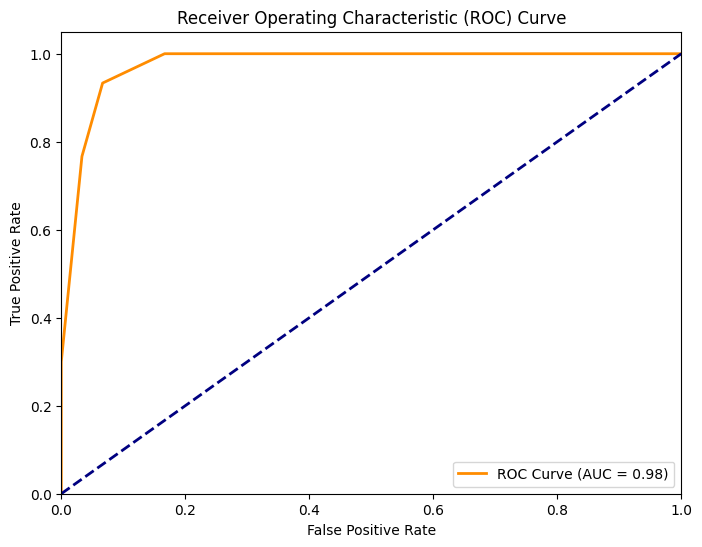

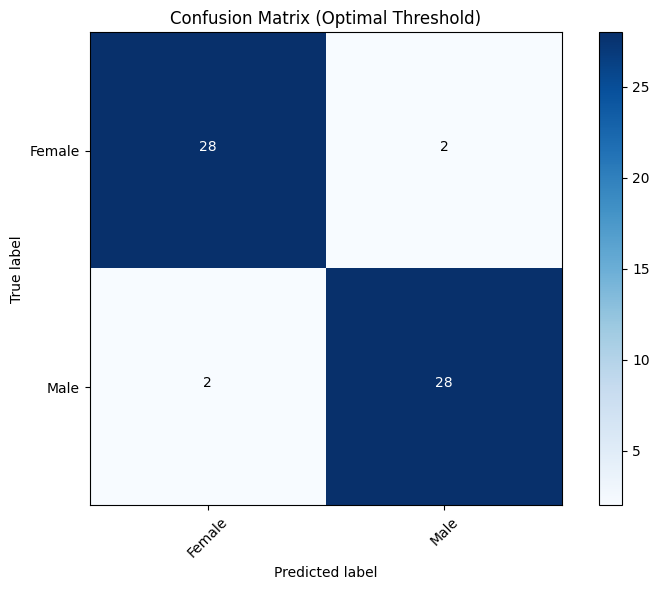

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

# Load features from JSON
def load_features(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    features = []
    labels = []
    for entry in data:
        label = 1 if entry['label'].lower() == 'male' else 0  # Convert gender to binary
        feature_vector = np.concatenate([
            np.mean(entry['features']['MFCC'], axis=1),  # Mean of MFCCs
            np.mean(entry['features']['Spectral Centroid'], axis=1),  # Mean of spectral centroid
            np.mean(entry['features']['Spectral Bandwidth'], axis=1)  # Mean of spectral bandwidth
        ])
        features.append(feature_vector)
        labels.append(label)
    return np.array(features), np.array(labels)

# Load the data
json_file = "extracted_features_dataset.json"
X, y = load_features(json_file)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Set k to 5 (default)
knn.fit(X_train, y_train)

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")

# Predict Probabilities for the Test Set
y_proba = knn.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (Male)

# Calculate Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Predict Using the Default Threshold (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)
default_accuracy = accuracy_score(y_test, y_pred_default)
print(f"\nDefault Accuracy: {default_accuracy:.2f}")

# Predict Using the Optimal Threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
optimized_accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized Accuracy: {optimized_accuracy:.2f}")

# Confusion Matrix and Classification Report for Default Threshold
print("\nClassification Report (Default Threshold):")
print(classification_report(y_test, y_pred_default, target_names=["Female", "Male"]))

conf_matrix_default = confusion_matrix(y_test, y_pred_default)
print("\nConfusion Matrix (Default Threshold):")
print(pd.DataFrame(conf_matrix_default, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

# Confusion Matrix and Classification Report for Optimal Threshold
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal, target_names=["Female", "Male"]))

conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix (Optimal Threshold):")
print(pd.DataFrame(conf_matrix_optimal, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for Optimal Threshold
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_optimal, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Optimal Threshold)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Female", "Male"], rotation=45)
plt.yticks(tick_marks, ["Female", "Male"])
thresh = conf_matrix_optimal.max() / 2.0
for i, j in np.ndindex(conf_matrix_optimal.shape):
    plt.text(j, i, f"{conf_matrix_optimal[i, j]}", 
             horizontalalignment="center", 
             color="white" if conf_matrix_optimal[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


# Gender Classification: SVM

Cross-Validation Accuracy Scores: [0.97222222 0.94444444 0.91666667 0.88888889 0.94444444]
Mean CV Accuracy: 0.93
Optimal Threshold: 0.41

Default Accuracy: 0.97
Optimized Accuracy: 0.98

Classification Report (Default Threshold):
              precision    recall  f1-score   support

      Female       0.97      0.97      0.97        30
        Male       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Confusion Matrix (Default Threshold):
               Predicted Female  Predicted Male
Actual Female                29               1
Actual Male                   1              29

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Female       1.00      0.97      0.98        30
        Male       0.97      1.00      0.98        30

    accuracy                           0.98        

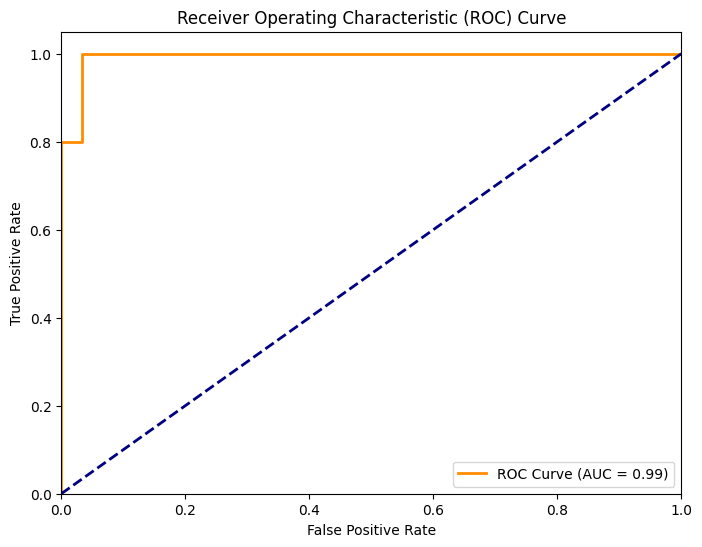

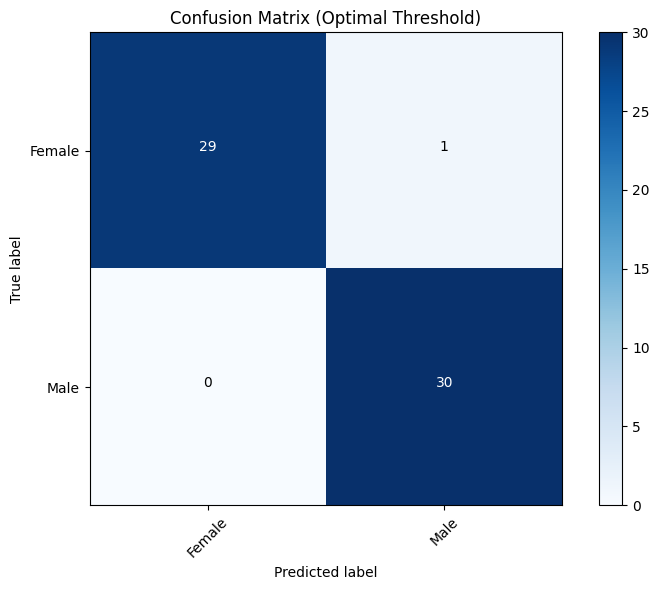

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

# Load features from JSON
def load_features(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    features = []
    labels = []
    for entry in data:
        label = 1 if entry['label'].lower() == 'male' else 0  # Convert gender to binary
        feature_vector = np.concatenate([
            np.mean(entry['features']['MFCC'], axis=1),  # Mean of MFCCs
            np.mean(entry['features']['Spectral Centroid'], axis=1),  # Mean of spectral centroid
            np.mean(entry['features']['Spectral Bandwidth'], axis=1)  # Mean of spectral bandwidth
        ])
        features.append(feature_vector)
        labels.append(label)
    return np.array(features), np.array(labels)

# Load the data
json_file = "extracted_features_dataset.json"
X, y = load_features(json_file)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier
svm = SVC(probability=True, kernel="rbf", C=1, gamma="scale", random_state=42)  # RBF kernel
svm.fit(X_train, y_train)

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(svm, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")

# Predict Probabilities for the Test Set
y_proba = svm.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (Male)

# Calculate Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Predict Using the Default Threshold (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)
default_accuracy = accuracy_score(y_test, y_pred_default)
print(f"\nDefault Accuracy: {default_accuracy:.2f}")

# Predict Using the Optimal Threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
optimized_accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized Accuracy: {optimized_accuracy:.2f}")

# Confusion Matrix and Classification Report for Default Threshold
print("\nClassification Report (Default Threshold):")
print(classification_report(y_test, y_pred_default, target_names=["Female", "Male"]))

conf_matrix_default = confusion_matrix(y_test, y_pred_default)
print("\nConfusion Matrix (Default Threshold):")
print(pd.DataFrame(conf_matrix_default, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

# Confusion Matrix and Classification Report for Optimal Threshold
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal, target_names=["Female", "Male"]))

conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix (Optimal Threshold):")
print(pd.DataFrame(conf_matrix_optimal, index=["Actual Female", "Actual Male"], columns=["Predicted Female", "Predicted Male"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix for Optimal Threshold
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_optimal, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Optimal Threshold)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Female", "Male"], rotation=45)
plt.yticks(tick_marks, ["Female", "Male"])
thresh = conf_matrix_optimal.max() / 2.0
for i, j in np.ndindex(conf_matrix_optimal.shape):
    plt.text(j, i, f"{conf_matrix_optimal[i, j]}", 
             horizontalalignment="center", 
             color="white" if conf_matrix_optimal[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


# Identitiy Authentication: Logistic Regression CLassifier

Class distribution: Counter({4: 98, 0: 72, 1: 25, 2: 25, 3: 20})
Class distribution after filtering: Counter({4: 98, 0: 72, 1: 25, 2: 25, 3: 20})
Model Accuracy: 0.4667
Classification Report:
              precision    recall  f1-score   support

          Q1       0.47      0.47      0.47        36
          Q2       0.07      0.08      0.07        13
          Q3       0.11      0.08      0.10        12
          Q4       0.00      0.00      0.00        10
       intro       0.69      0.76      0.72        49

    accuracy                           0.47       120
   macro avg       0.27      0.28      0.27       120
weighted avg       0.44      0.47      0.45       120



C:\Users\Shayan\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


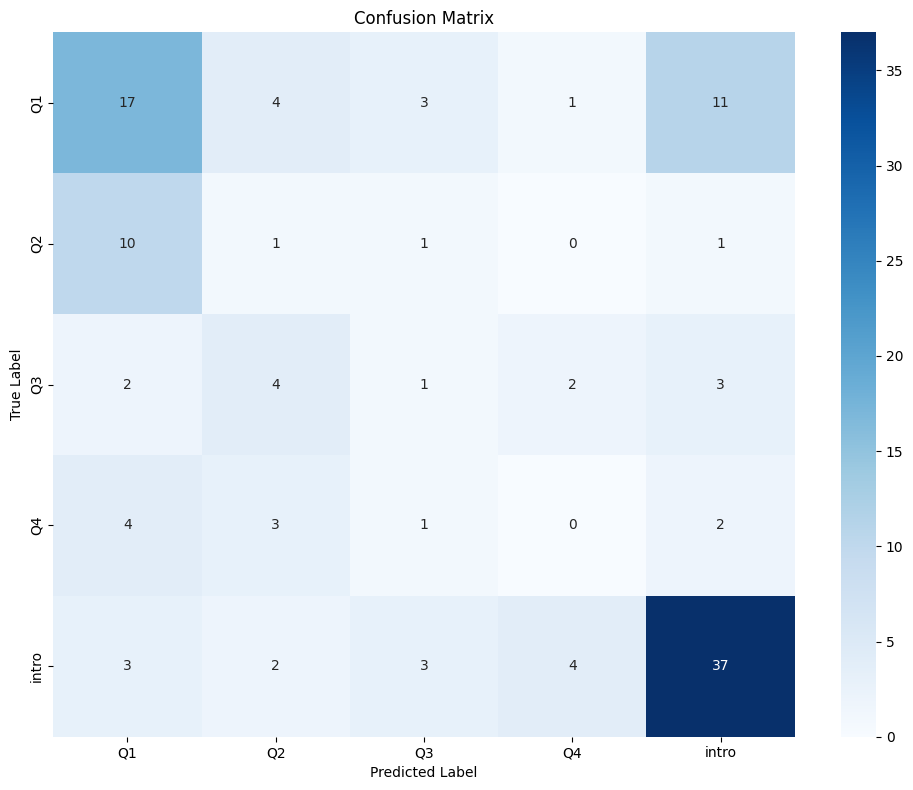

In [12]:
from math import ceil
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load extracted features from JSON file
input_file = "extracted_features_dataset.json"
with open(input_file, "r") as f:
    features_data = json.load(f)

# Extract feature vectors and student IDs
X = []  # Features
Y = []  # Labels (student IDs)

for entry in features_data:
    student_id = entry["student_id"]
    features = entry["features"]
    
    # Flatten all feature arrays into a single feature vector
    feature_vector = []
    for key in features.keys():
        feature_vector.extend(np.mean(features[key], axis=1))  # Use mean of each feature
    
    X.append(feature_vector)
    Y.append(student_id)

# Convert to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# Encode student IDs into numerical labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)  # Convert student_id to numerical classes

class_counts = Counter(Y_encoded)
print("Class distribution:", class_counts)

# Get student IDs that appear at least twice
valid_classes = [cls for cls, count in class_counts.items() if count > 1]

# Filter dataset to keep only valid classes
X_filtered = [X[i] for i in range(len(Y_encoded)) if Y_encoded[i] in valid_classes]
Y_filtered = [Y_encoded[i] for i in range(len(Y_encoded)) if Y_encoded[i] in valid_classes]

# Convert to NumPy arrays
X_filtered = np.array(X_filtered)
Y_filtered = np.array(Y_filtered)

# Print class distribution after filtering
class_counts_filtered = Counter(Y_filtered)
print("Class distribution after filtering:", class_counts_filtered)

# Normalize features for better model performance (Apply after filtering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Compute minimum required test size to ensure at least one sample per class
min_test_size = ceil(len(set(Y_filtered)) / len(Y_filtered))

# Use the larger of 25% or min_test_size
#test_size = max(0.25, min_test_size)

# Perform train-test split without error
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_filtered, test_size=0.5, random_state=42, stratify=Y_filtered
)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:")

# After final filtering (X_filtered, Y_filtered)
final_classes = np.unique(Y_filtered)  # numeric classes actually in your data
target_names = label_encoder.inverse_transform(final_classes)  # map numeric classes back to IDs

print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# -------------------------------
# Add Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

# Plot confusion matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Identitiy Authentication: KNN CLassifier

Model Accuracy: 0.3167
Classification Report:
              precision    recall  f1-score   support

          Q1       0.27      0.22      0.24        36
          Q2       0.06      0.08      0.07        13
          Q3       0.08      0.08      0.08        12
          Q4       0.00      0.00      0.00        10
       intro       0.55      0.57      0.56        49

    accuracy                           0.32       120
   macro avg       0.19      0.19      0.19       120
weighted avg       0.32      0.32      0.32       120



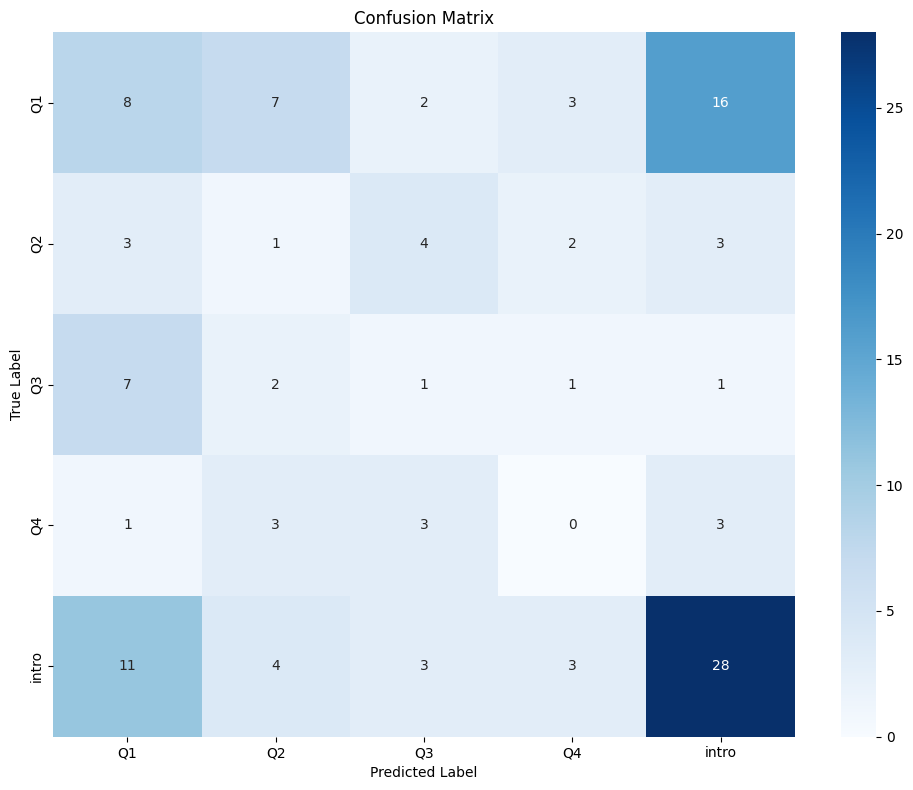

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Train K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:")

# After final filtering (X_filtered, Y_filtered)
final_classes = np.unique(Y_filtered)  # numeric classes actually in your data
target_names = label_encoder.inverse_transform(final_classes)  # map numeric classes back to IDs

print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# -------------------------------
# Add Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

# Plot confusion matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Identitiy Authentication: MLP CLassifier

Model Accuracy: 0.4083
Classification Report:
              precision    recall  f1-score   support

          Q1       0.35      0.39      0.37        36
          Q2       0.11      0.15      0.13        13
          Q3       0.00      0.00      0.00        12
          Q4       0.00      0.00      0.00        10
       intro       0.65      0.67      0.66        49

    accuracy                           0.41       120
   macro avg       0.22      0.24      0.23       120
weighted avg       0.38      0.41      0.39       120



C:\Users\Shayan\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


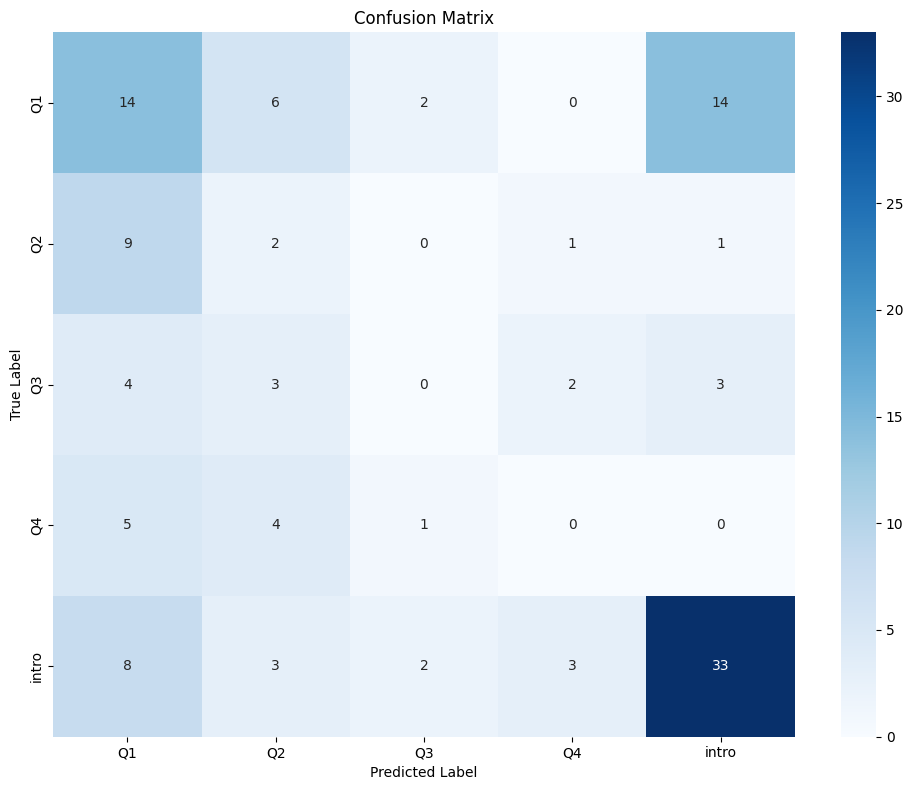

In [14]:
from sklearn.neural_network import MLPClassifier

# Train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(99,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:")

# After final filtering (X_filtered, Y_filtered)
final_classes = np.unique(Y_filtered)  # numeric classes actually in your data
target_names = label_encoder.inverse_transform(final_classes)  # map numeric classes back to IDs

print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# -------------------------------
# Add Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

# Plot confusion matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Identitiy Authentication: SVM CLassifier

Model Accuracy: 0.3750
Classification Report:
              precision    recall  f1-score   support

          Q1       0.30      0.33      0.32        36
          Q2       0.00      0.00      0.00        13
          Q3       0.00      0.00      0.00        12
          Q4       0.00      0.00      0.00        10
       intro       0.63      0.67      0.65        49

    accuracy                           0.38       120
   macro avg       0.19      0.20      0.19       120
weighted avg       0.35      0.38      0.36       120



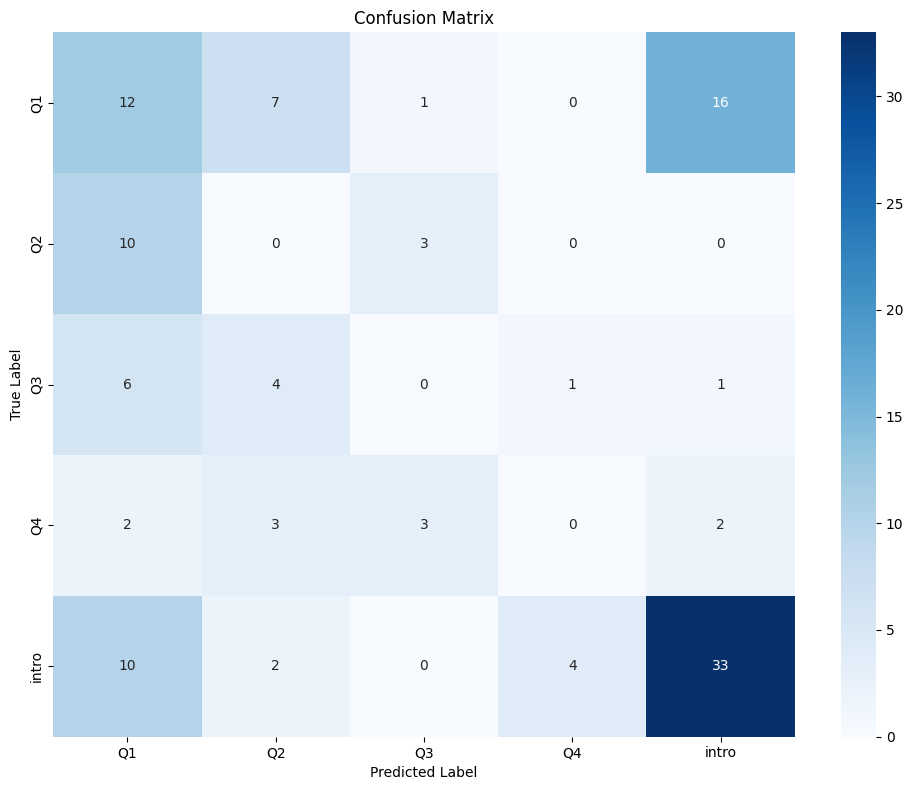

In [15]:
from sklearn.svm import SVC

# Train SVM classifier
svm_clf = SVC(kernel='rbf', gamma='scale', C=5, random_state=42)
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:")

# After final filtering (X_filtered, Y_filtered)
final_classes = np.unique(Y_filtered)  # numeric classes actually in your data
target_names = label_encoder.inverse_transform(final_classes)  # map numeric classes back to IDs

print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# -------------------------------
# Add Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

# Plot confusion matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Clustering: K-Means & Heirarchical

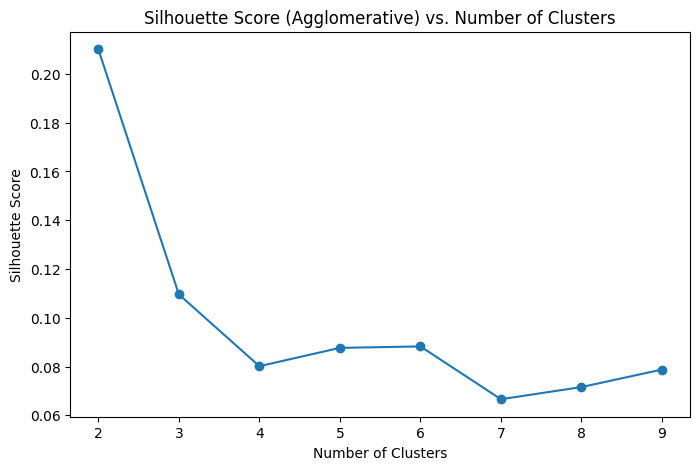

Optimal Number of Clusters: 2


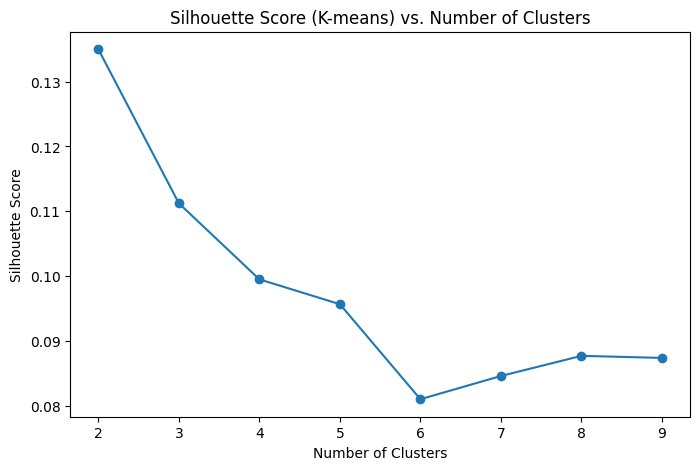

Optimal Number of Clusters: 2


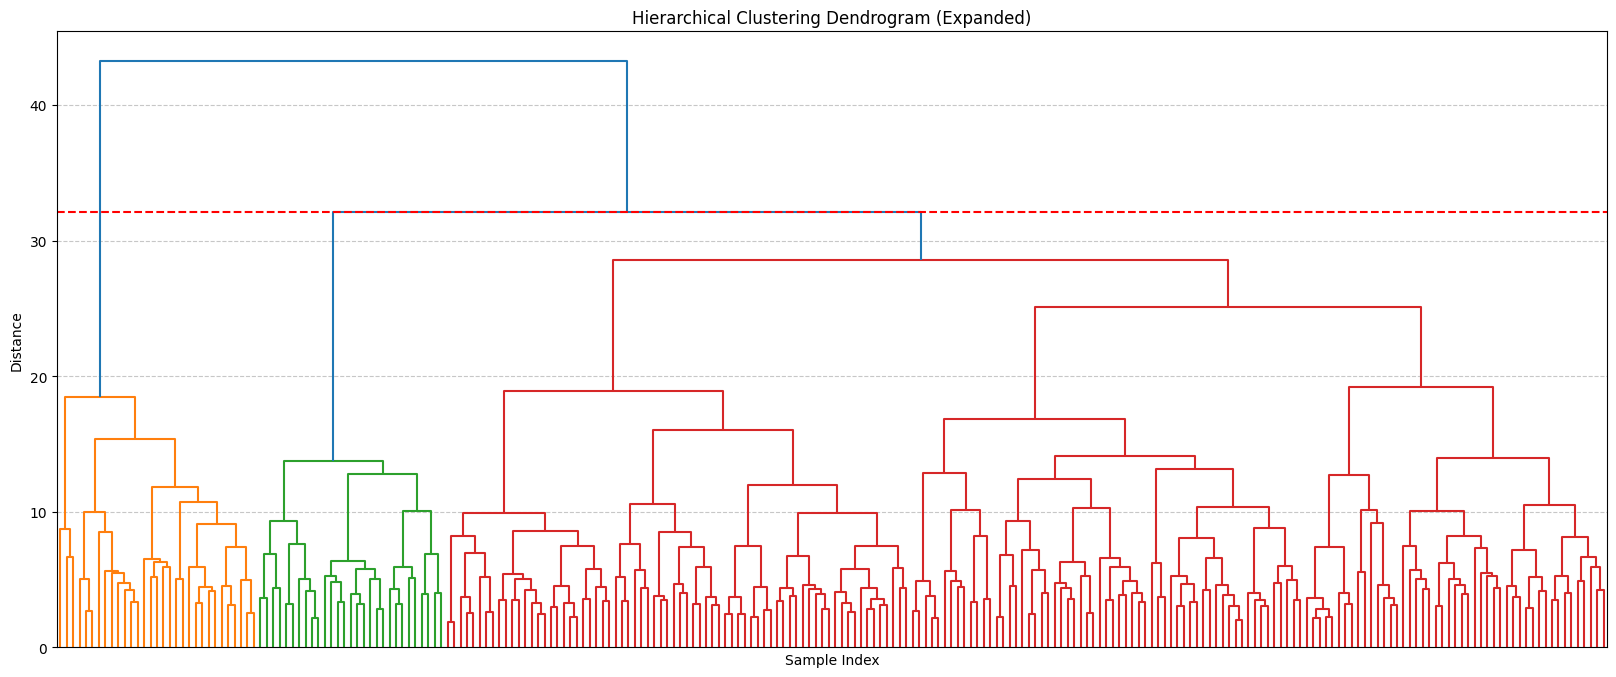

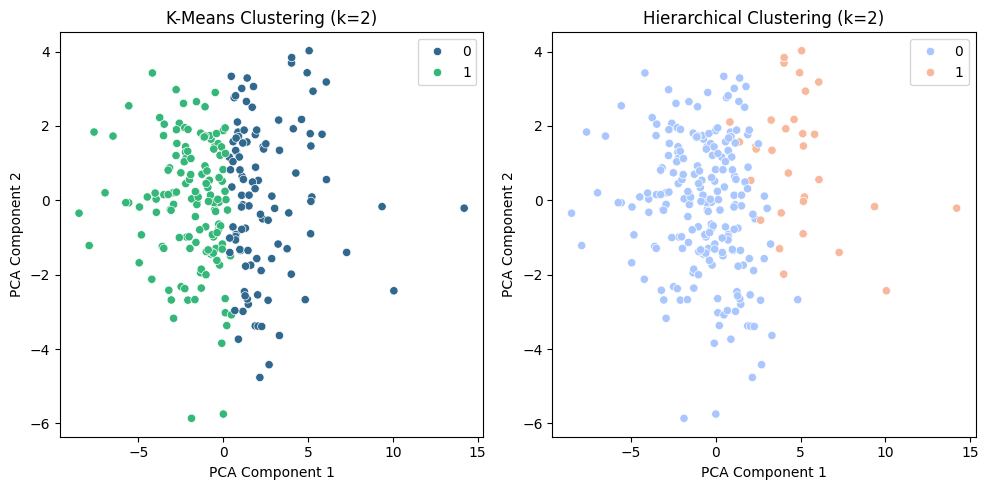

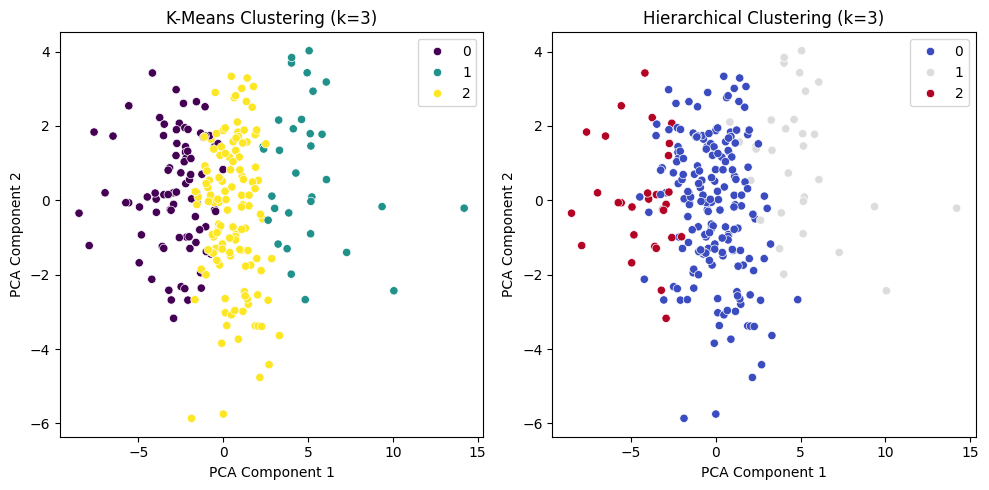

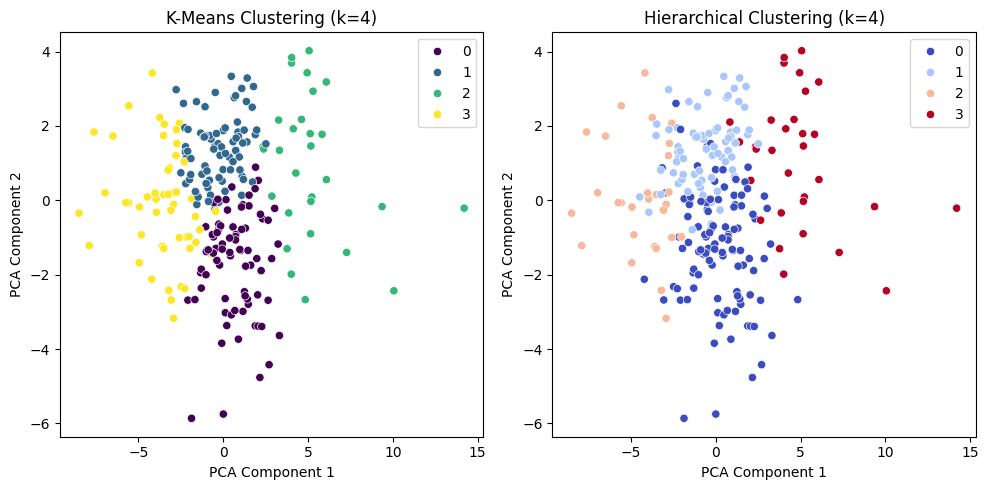

In [16]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Load extracted features
with open("extracted_features_dataset.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Extract relevant numerical features
feature_keys = ["MFCC", "Spectral Centroid", "Energy"]
X = []
for entry in df["features"]:
    feature_vector = []
    for key in feature_keys:
        if key in entry:
            feature_vector.extend(np.mean(entry[key], axis=1))  # Aggregate mean
            feature_vector.extend(np.std(entry[key], axis=1))   # Aggregate std
    X.append(feature_vector)

X = np.array(X)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal clusters for Heirarchical clustering using Silhouette Score
sil_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, sil_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score (Agglomerative) vs. Number of Clusters")
plt.show()

# Select the best number of clusters (e.g., highest silhouette score)
optimal_k = cluster_range[np.argmax(sil_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")

# Determine optimal clusters for K-means clustering using Silhouette Score
sil_scores = []
cluster_range = range(2, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, sil_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score (K-means) vs. Number of Clusters")
plt.show()

# Select the best number of clusters (e.g., highest silhouette score)
optimal_k = cluster_range[np.argmax(sil_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage

# Perform hierarchical clustering
plt.figure(figsize=(20, 8)) 
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
dendrogram(
    linkage_matrix,
    truncate_mode=None,  # Show full dendrogram
    leaf_rotation=90,  
    leaf_font_size=8,  
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # Color clusters for clarity
)

# Add horizontal line to indicate the optimal number of clusters (k=2)
plt.axhline(y=linkage_matrix[-2, 2], color='r', linestyle='--')  # Adjust y-position based on linkage matrix

plt.title("Hierarchical Clustering Dendrogram (Expanded)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")

# Fix x-axis overcrowding
plt.xticks([])  # Remove individual labels to prevent overlap
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a subtle grid

plt.show()



# Compare clustering results with PCA visualization
from sklearn.decomposition import PCA

# Compare clustering results with PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title(f"K-Means Clustering (k={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hierarchical_labels, palette='coolwarm')
plt.title(f"Hierarchical Clustering (k={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

# Perform clustering for additional values of k
alternative_k_values = [optimal_k + 1, optimal_k + 2]
for k in alternative_k_values:
    kmeans_alt = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels_alt = kmeans_alt.fit_predict(X_scaled)
    
    hierarchical_alt = AgglomerativeClustering(n_clusters=k)
    hierarchical_labels_alt = hierarchical_alt.fit_predict(X_scaled)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels_alt, palette='viridis')
    plt.title(f"K-Means Clustering (k={k})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hierarchical_labels_alt, palette='coolwarm')
    plt.title(f"Hierarchical Clustering (k={k})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    
    plt.tight_layout()
    plt.show()
